# Reproducing experiment 6.2 from Tramdag paper

In [1]:
import os
# from tramdag.utils.configuration import *

from tramdag import TramDagConfig
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "plot_ordinal_trafo_fkt"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")
cfg=TramDagConfig()
cfg.setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/configuration.json


Setting seed: 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB
Train size: 80000, Validation size: 10000, Test size: 10000


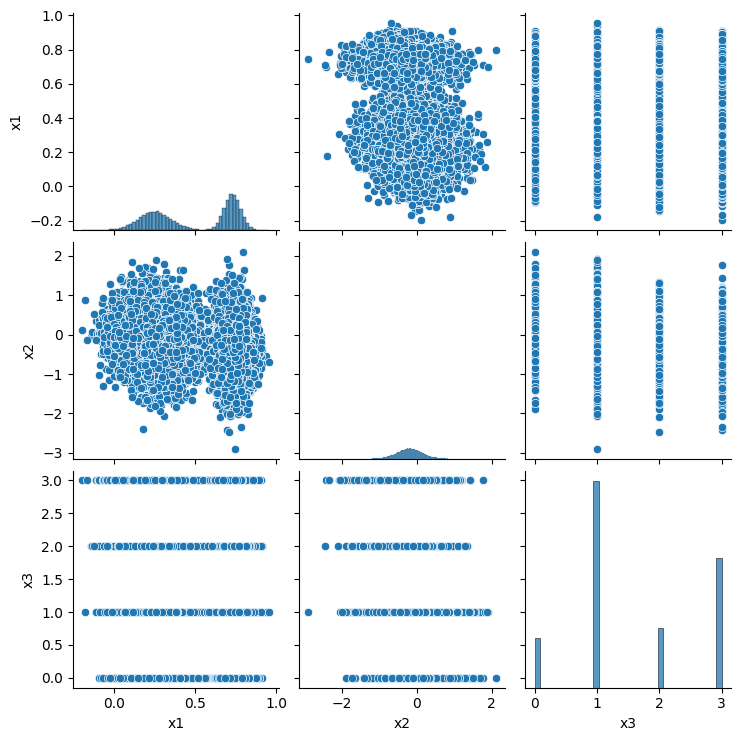

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

df = dgp(n_obs=100_000, seed=42)
df.info()
sns.pairplot(df)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


In [4]:
data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 
cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/configuration.json.


/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


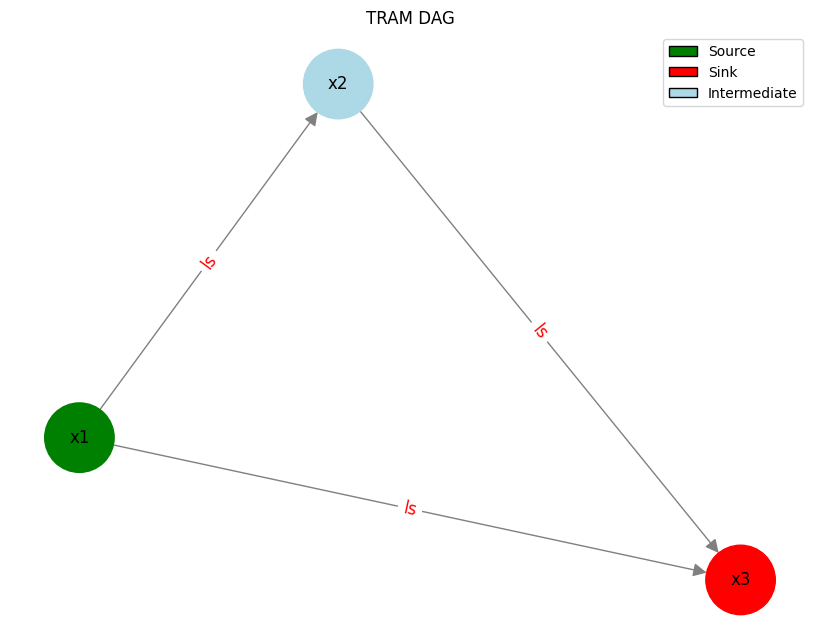

In [5]:
cfg.set_meta_adj_matrix()



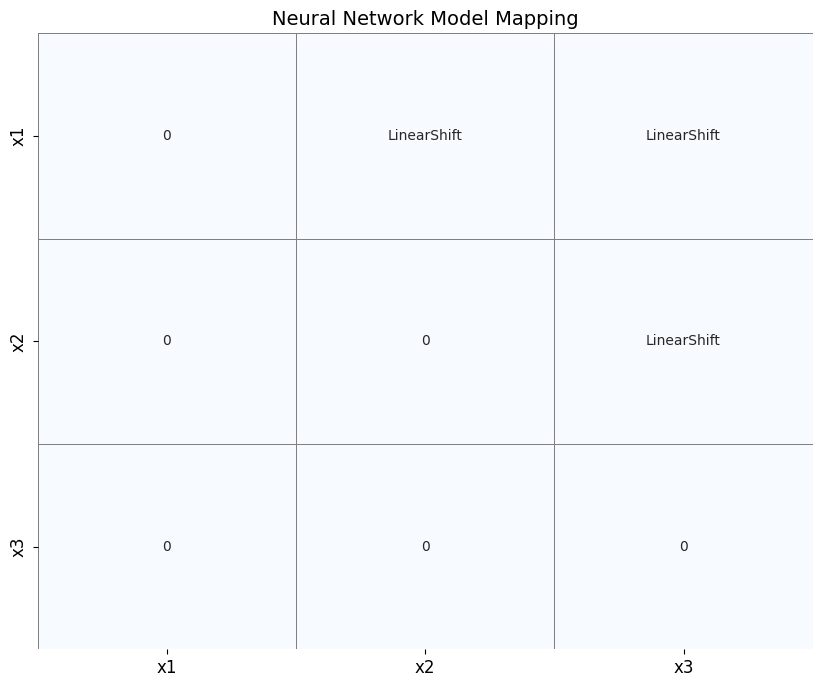

In [6]:
cfg.set_tramdag_nn_models()

# Model training & sampling

In [7]:
from tramdag import TramDagModel

cfg.compute_levels(train_df)
device='cpu'

In [8]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data = train_df) 


In [9]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=200,batch_size=1000,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/min_max_scaling.json
[INFO] Training 3 nodes (sequential) on cpu

[INFO] Training node 'x1' for 200 epochs on cpu (pid=2371493)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x2' for 200 epochs on cpu (pid=2371493)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x3' for 200 epochs on cpu (pid=2371493)
[INFO] Existing model found. Loading weights and history from LAST model...


[INFO] Loaded training/validation histories for 3 nodes.


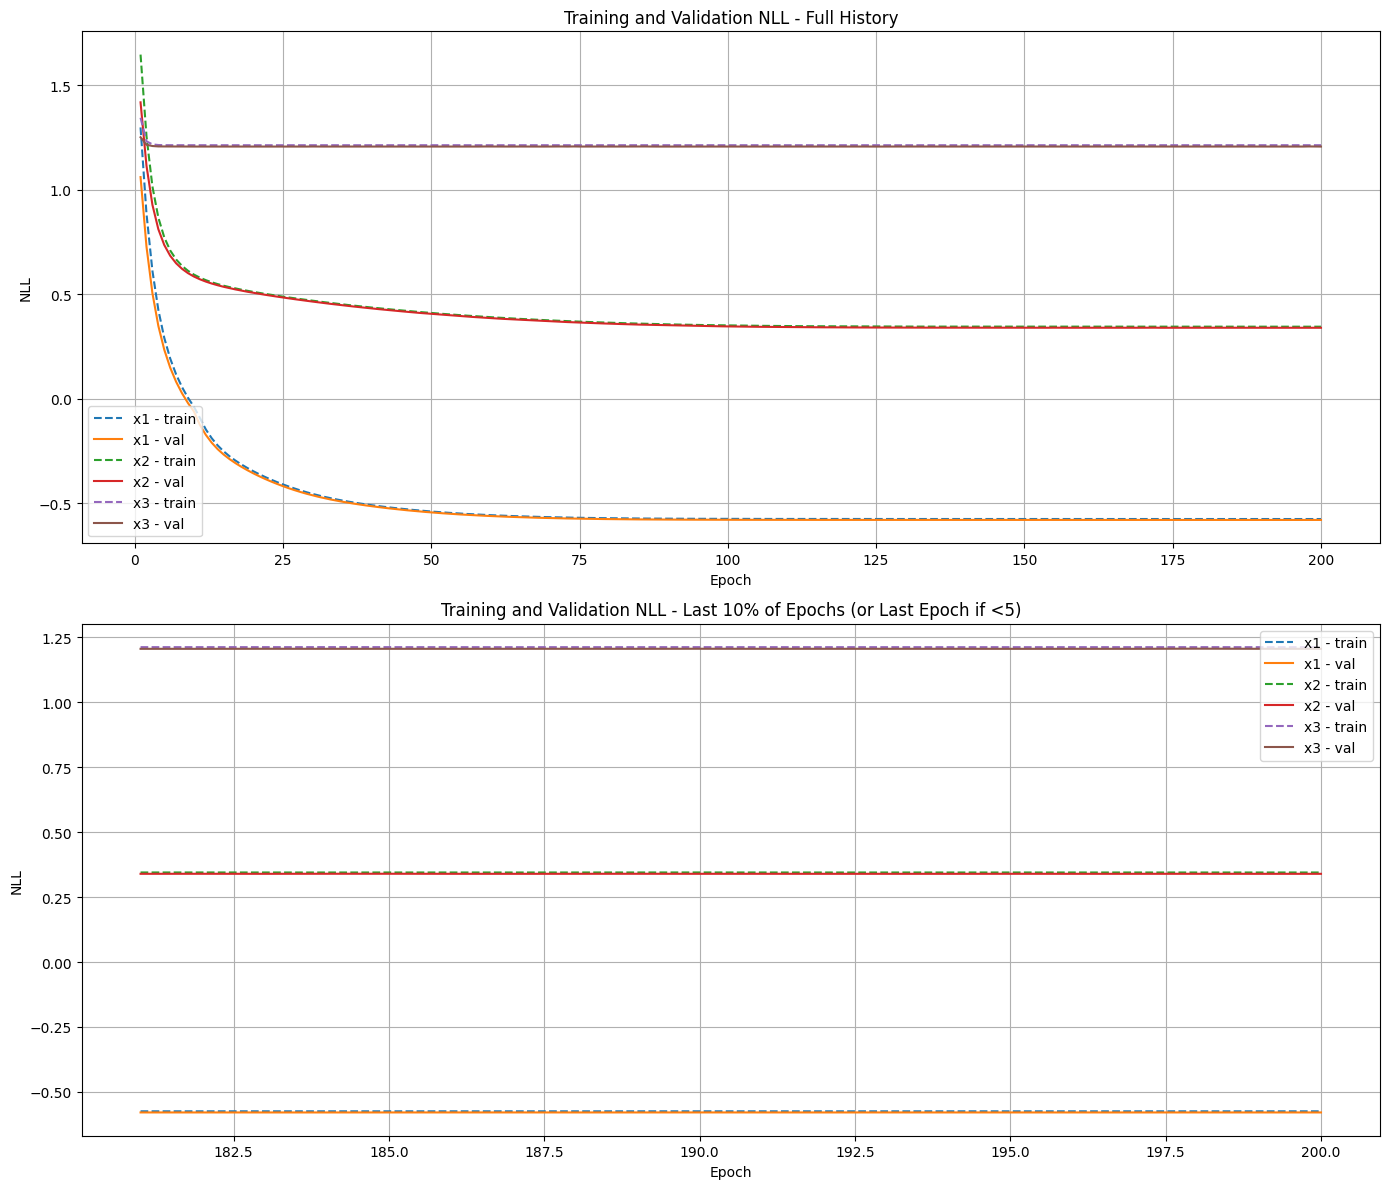

In [10]:
td_model.plot_loss_history()

```
  Continuous Outcome Logistic Regression 

Call:
Colr(formula = x2 ~ x1, data = data_6_2)

Coefficients:
      x1 
1.973891 

Log-Likelihood:
 -31293.99 (df = 8)
```
---------------------------------------------------
```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 
```

[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/tramdag/TramDagModel.py:924: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(flatten)


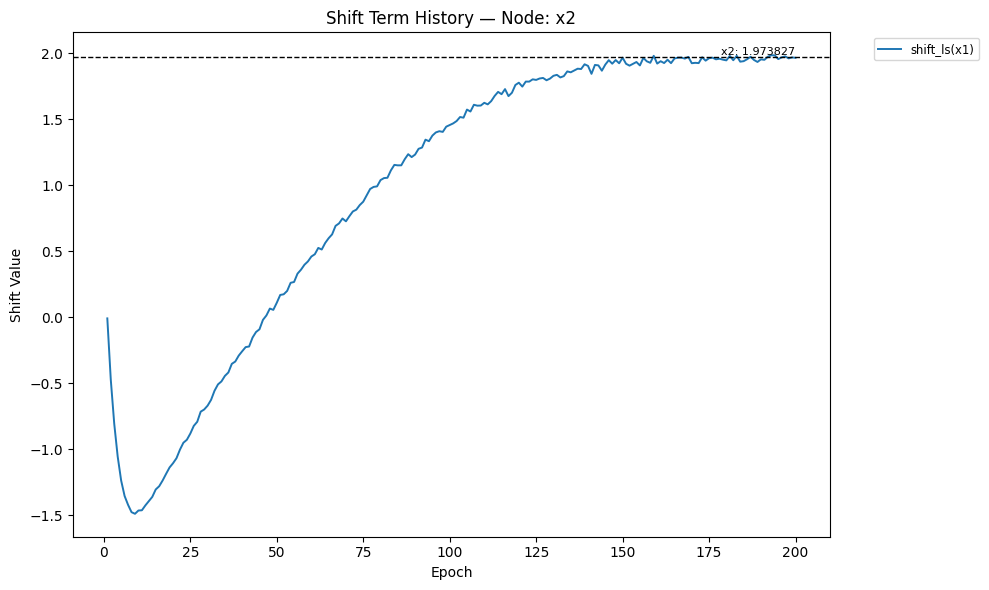

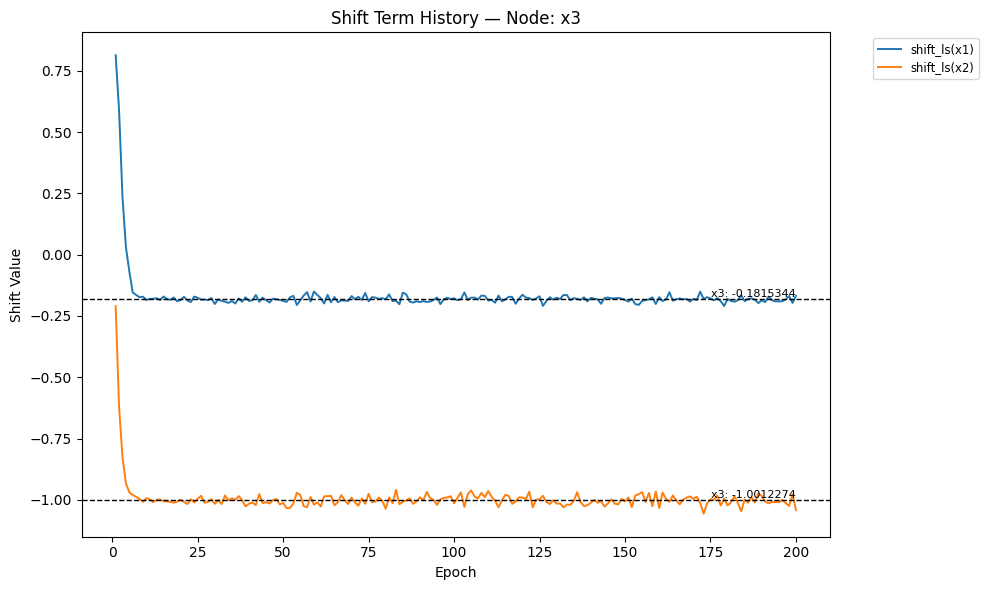

In [11]:
td_model.plot_linear_shift_history(ref_lines={'x2':[1.973827],'x3':[-0.1815344, -1.0012274 ]}) 

```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 

# Intercepts:
#       0|1       1|2       2|3 
# -1.998953  0.426397  1.032376 

# Residual Deviance: 194022.51 
# AIC: 194032.51 
```

avg NLL
194022.51 /( 2 *80_000) =  1.2126406875


/home/bule/TramDag/tramdag/TramDagModel.py:977: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


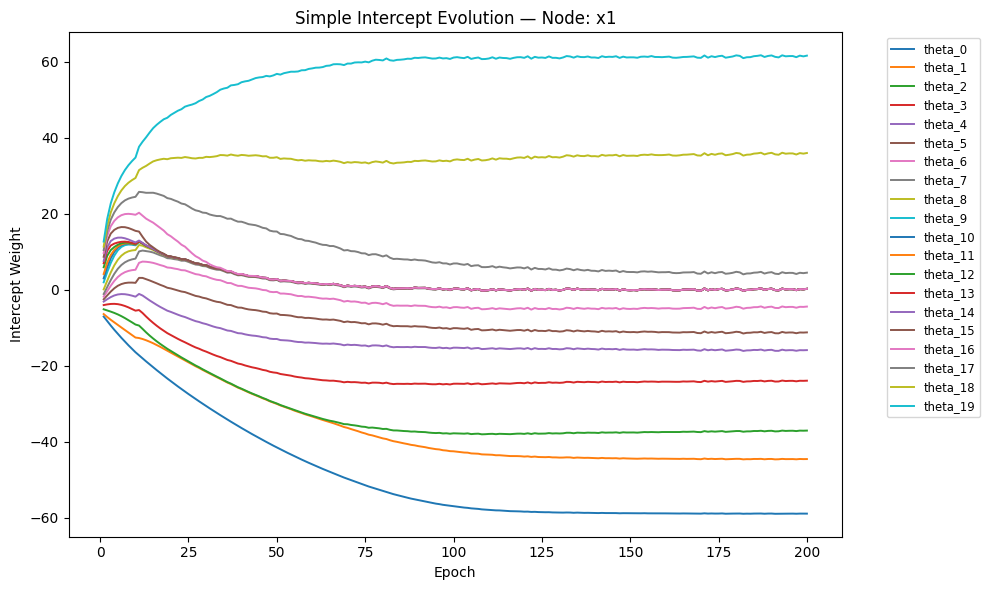

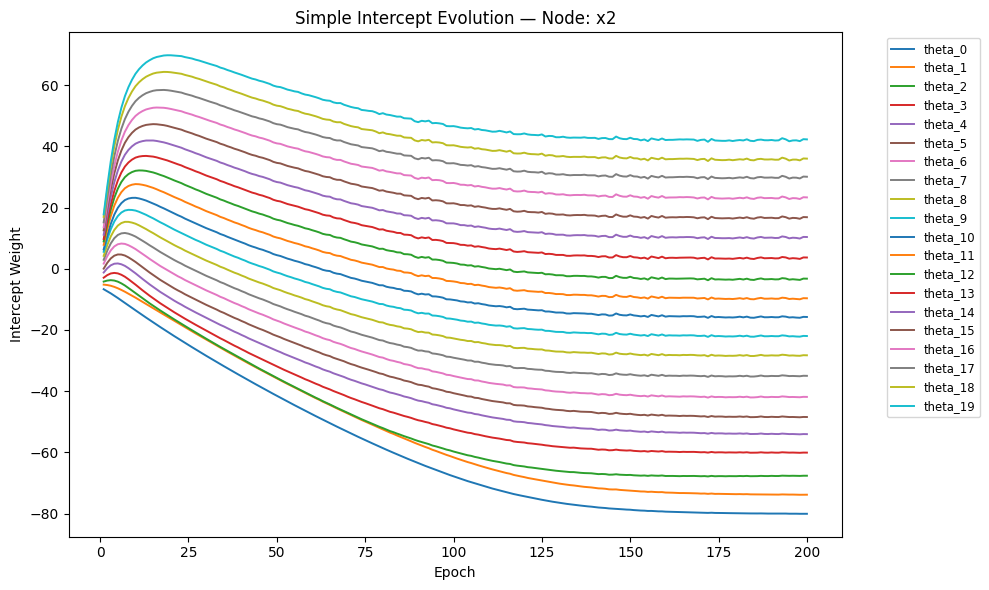

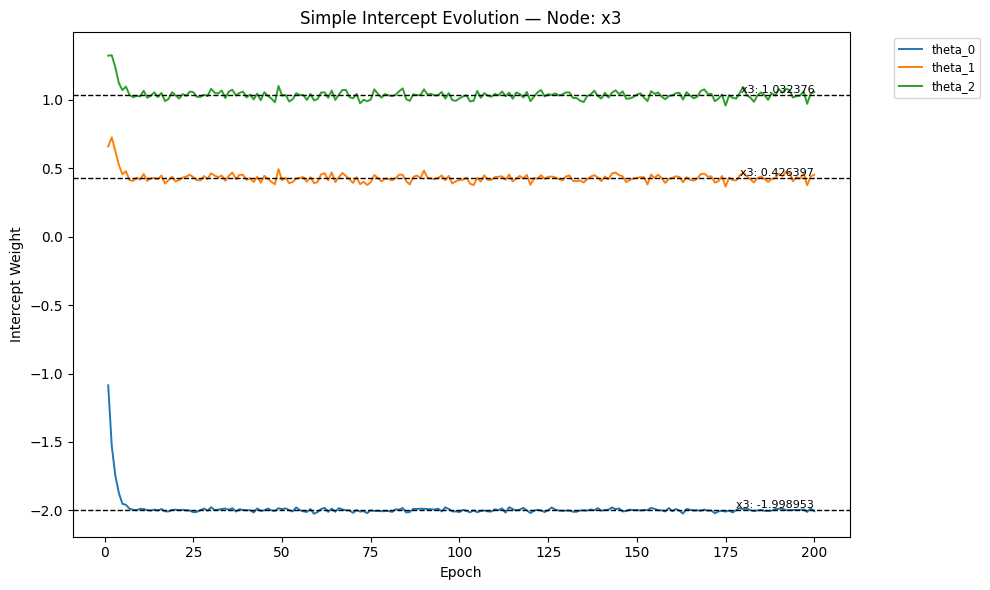

In [12]:
# # [-2.054361   0.3095475  0.897935 ]

td_model.plot_simple_intercepts_history(ref_lines={'x3':[-1.998953,  0.426397,  1.032376]})

[WARNING] len(df)>1, set: plot_n_rows accordingly
x1: Simple intercept — identical h() for all samples.


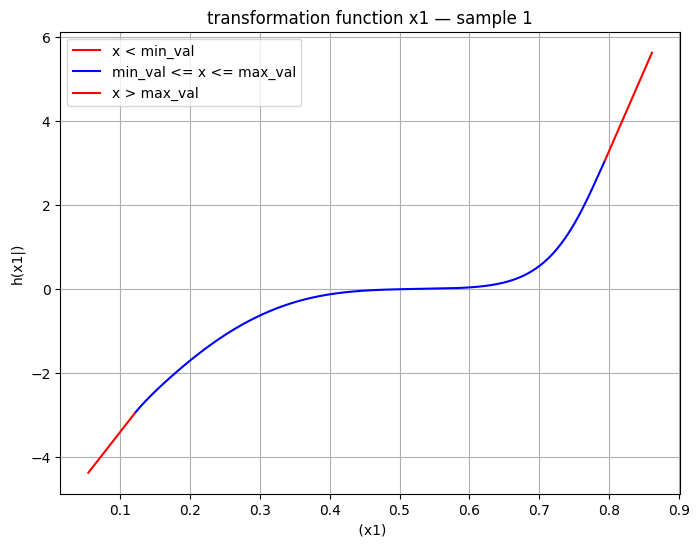


=== Sample 1/1 ===
x1    0.729475
x2   -0.573516
x3    0.000000
Name: 75220, dtype: float64


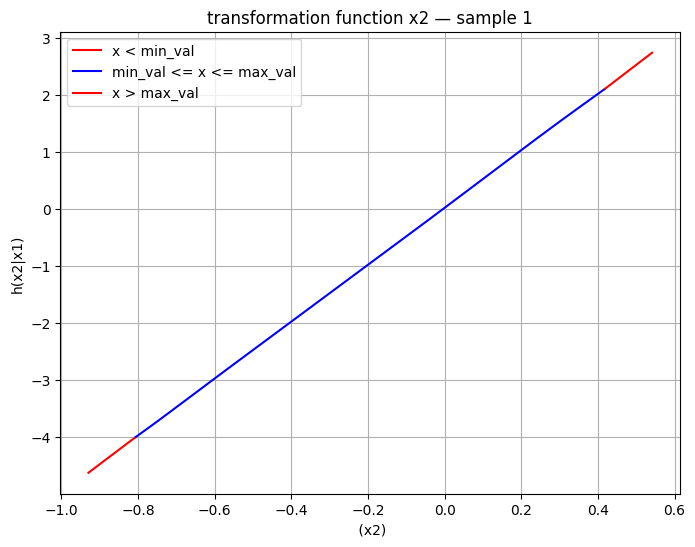

[WARNING] Node x3 is categorical, in development...

=== Sample 1/1 ===
x1    0.729475
x2   -0.573516
x3    0.000000
Name: 75220, dtype: float64


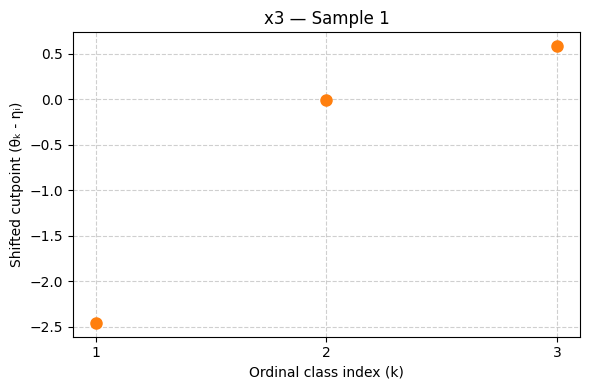

In [13]:
td_model.plot_hdag(train_df,variables=['x1','x2','x3'],plot_n_rows=1)

In [14]:
# def compute_ordinal_nll_and_confusion_from_file(pred_csv_path):
#     import numpy as np
#     import pandas as pd
#     from sklearn.metrics import confusion_matrix

#     preds = pd.read_csv(pred_csv_path)

#     def parse_list(x):
#         if isinstance(x, str):
#             return np.array(eval(x))
#         return np.array(x)

#     nlls = []
#     true_classes = []
#     pred_classes = []

#     for _, row in preds.iterrows():
#         probs = parse_list(row["probs"])
#         y = int(row["x3"])
#         p = probs[y] if y < len(probs) else 1e-9
#         nlls.append(-np.log(p + 1e-9))
#         true_classes.append(y)
#         pred_classes.append(int(np.argmax(probs)))

#     preds["true_class"] = true_classes
#     preds["pred_class"] = pred_classes
#     preds["nll"] = nlls

#     mean_nll = float(np.mean(nlls))
#     cm = confusion_matrix(true_classes, pred_classes)

#     out_path = pred_csv_path.replace(".csv", "_with_nll.csv")
#     preds.to_csv(out_path, index=False)

#     cm_path = pred_csv_path.replace(".csv", "_confusion_matrix.csv")
#     pd.DataFrame(cm).to_csv(cm_path, index=False)

#     print(f"Mean NLL: {mean_nll:.6f}")
#     print(f"Saved file with NLLs: {out_path}")
#     print(f"Saved confusion matrix: {cm_path}")

#     return mean_nll, cm

# compute_ordinal_nll_and_confusion_from_file("/home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3_ordinal_predictions_full_20251109_083637.csv")
# cm_path = "/home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3_ordinal_predictions_full_20251109_083637_confusion_matrix.csv"
# print(pd.read_csv(cm_path))

In [30]:
one_sample_df=pd.DataFrame(train_df.iloc[0])
one_sample_df

,75220
x1,0.729475
x2,-0.573516
x3,0.000000


In [31]:
td_model.get_latent(  df = train_df) # return of df should be x3_U_lower X3_U_upper

[INFO] ordinal under development... '
[INFO] Final latent DataFrame shape: (80000, 7)


,x1,x1_U,x2,x2_U,x3,x3_U_low,x3_U_upper
75220,0.729475,1.035731,-0.573516,-1.386047,0,-inf,-2.458381
48955,0.212327,-1.542975,-0.198221,-0.543502,3,0.873767,inf
44966,0.219109,-1.456738,0.129154,1.113687,1,-1.834238,0.611994
13568,0.777640,2.451233,0.816980,5.706396,1,-1.039684,1.406548
92727,0.357308,-0.279121,-0.411472,-1.320169,3,0.682628,inf
...,...,...,...,...,...,...,...
6265,0.700518,0.550732,-0.365170,-0.407135,0,-inf,-2.252086
54886,0.217960,-1.471166,-0.776592,-3.419363,2,-0.306877,0.288119
76820,0.209427,-1.580598,-0.405457,-1.583794,3,0.663070,inf
860,0.741015,1.303719,0.424173,3.611836,0,-inf,-1.444452


[INFO] ordinal under development... '
[INFO] Final latent DataFrame shape: (80000, 7)


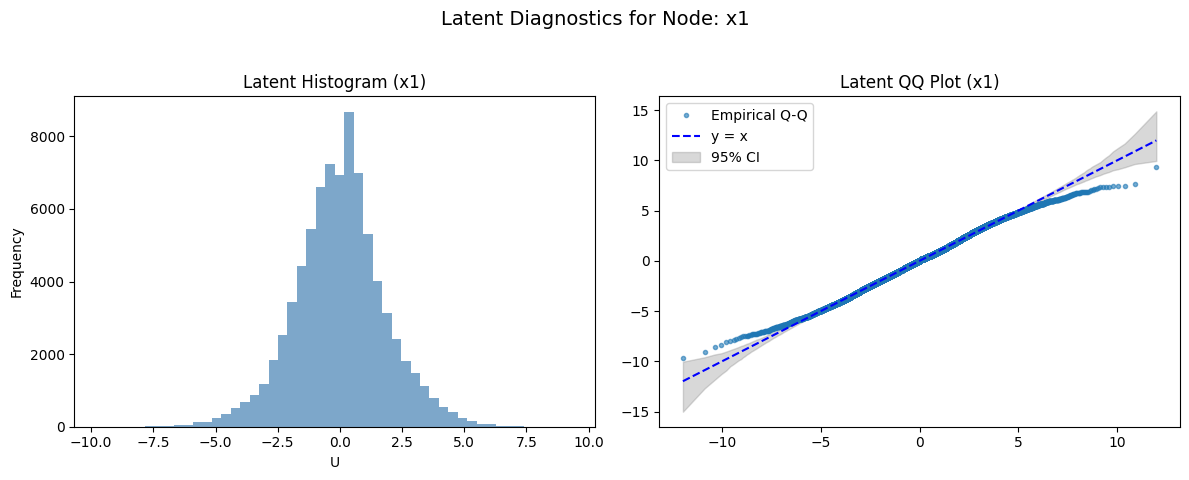

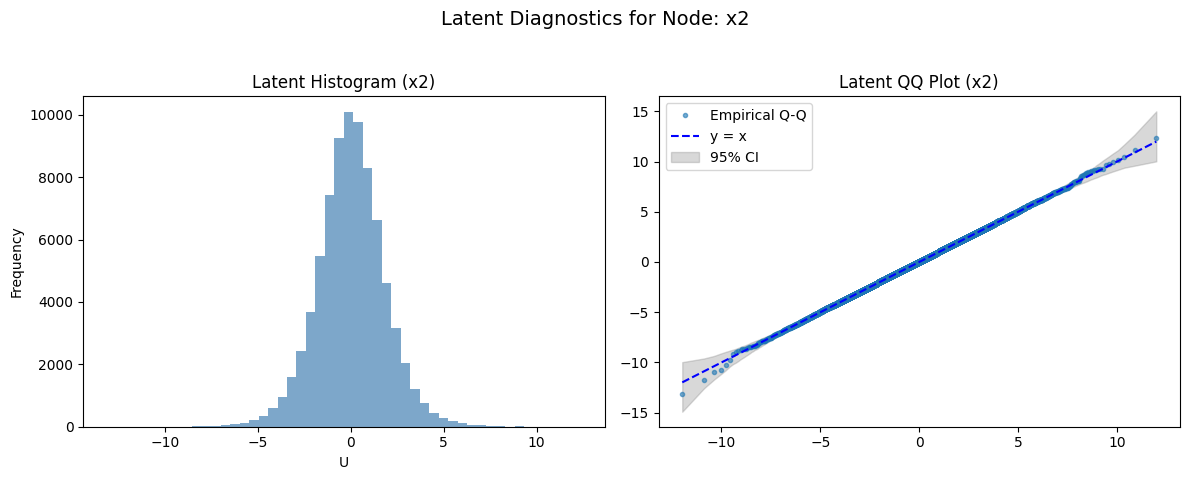

[WARNING] No latent found for node x3, skipping.


In [29]:
td_model.plot_latents(train_df)

In [17]:
td_model.nll(train_df)

KeyboardInterrupt: 

[INFO] Starting full DAG sampling with 1000 samples per node.
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[INFO] Loaded best model weights for node 'x1' from /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x1/best_model.pt
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 294.28it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[INFO] Loaded best model weights for node 'x2' from /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x2/best_model.pt
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 337.66it/s]


[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[INFO] Loaded best model weights for node 'x3' from /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3/best_model.pt
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?
[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


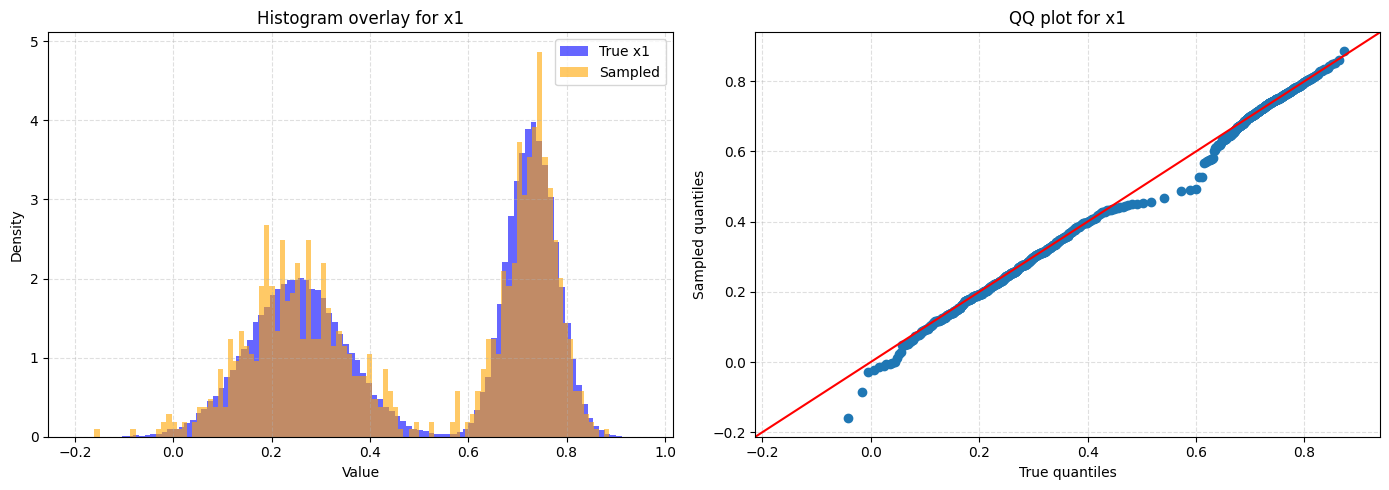

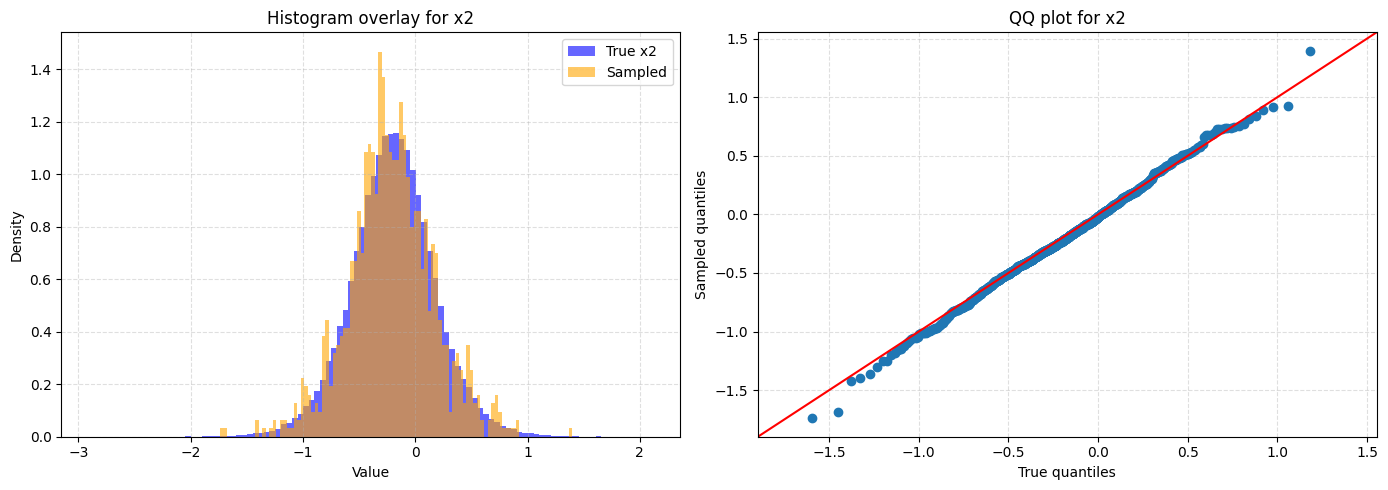

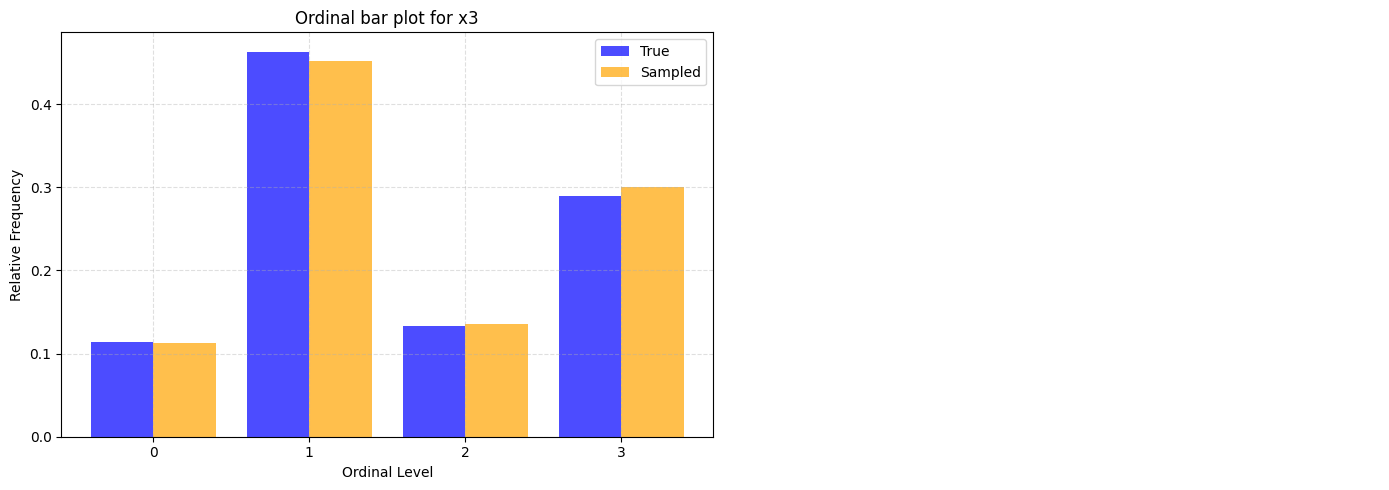

In [ ]:
rsamples, latents = td_model.sample(number_of_samples=1_000)
td_model.plot_samples_vs_true(train_df,rsamples)


[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['x1']
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'x1' with value -3.0
[INFO] Interventional data for node x1 is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[INFO] Loaded best model weights for node 'x2' from /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x2/best_model.pt
[WARNING] target_col 'x2' not in

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[INFO] Loaded best model weights for node 'x3' from /home/bule/TramDag/dev_experiment_logs/plot_ordinal_trafo_fkt/x3/best_model.pt
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


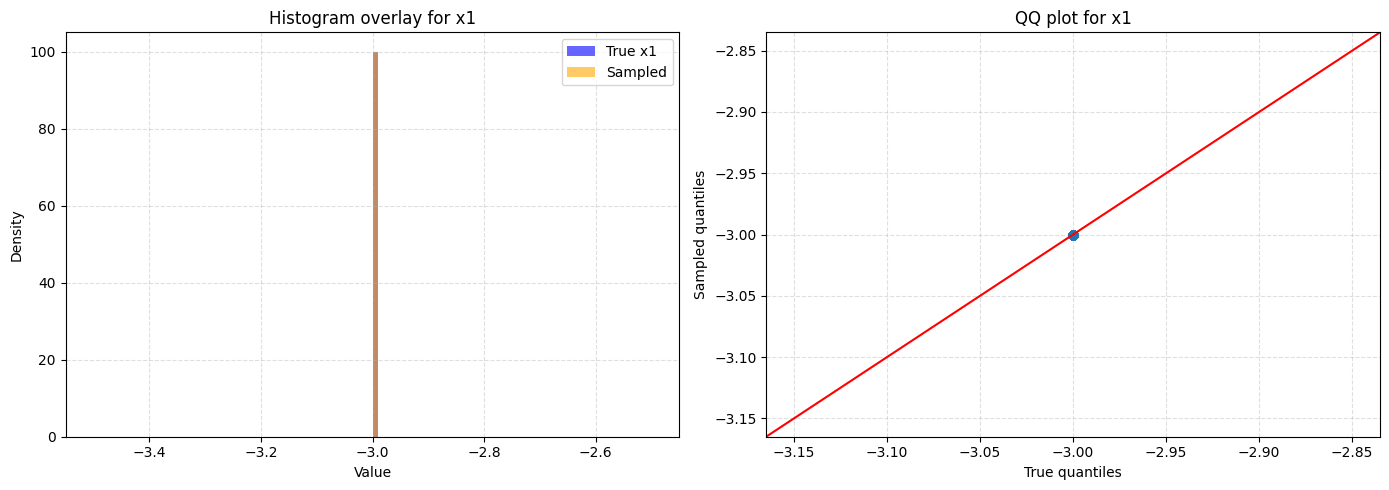

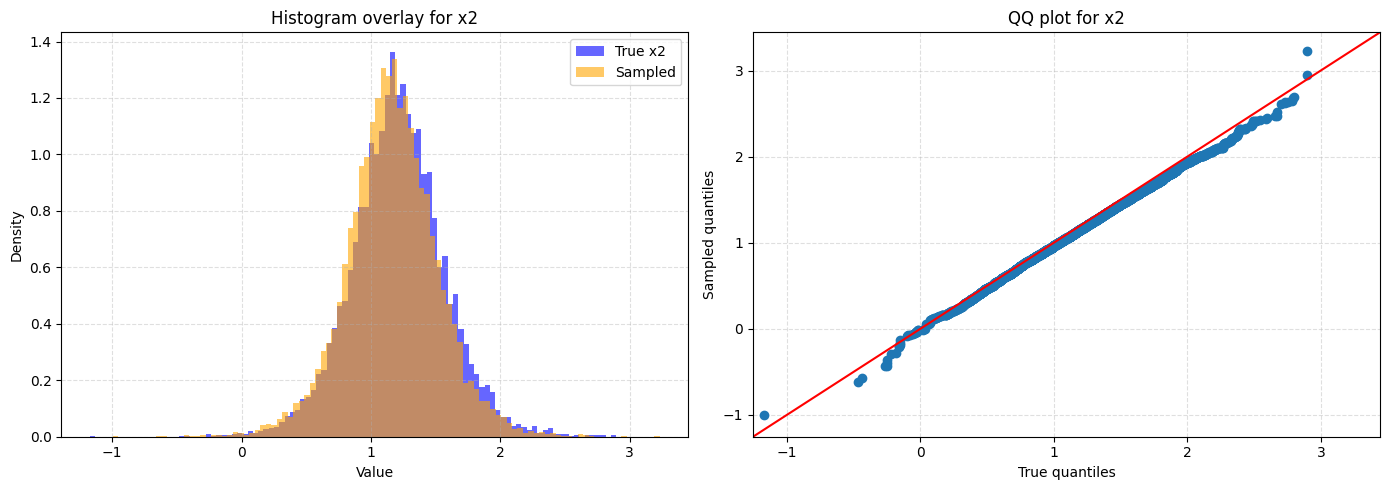

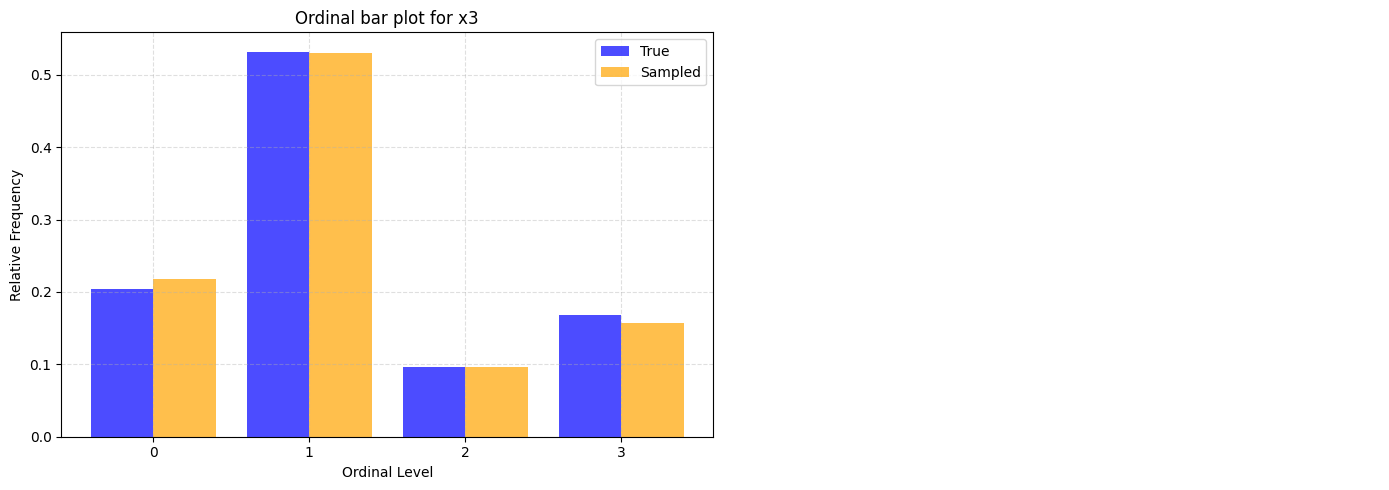

In [ ]:
samples, latents = td_model.sample(do_interventions={'x1':-3.0})
inter_df=dgp(n_obs=10_000, doX=[-3,None , None])
td_model.plot_samples_vs_true(inter_df,samples)

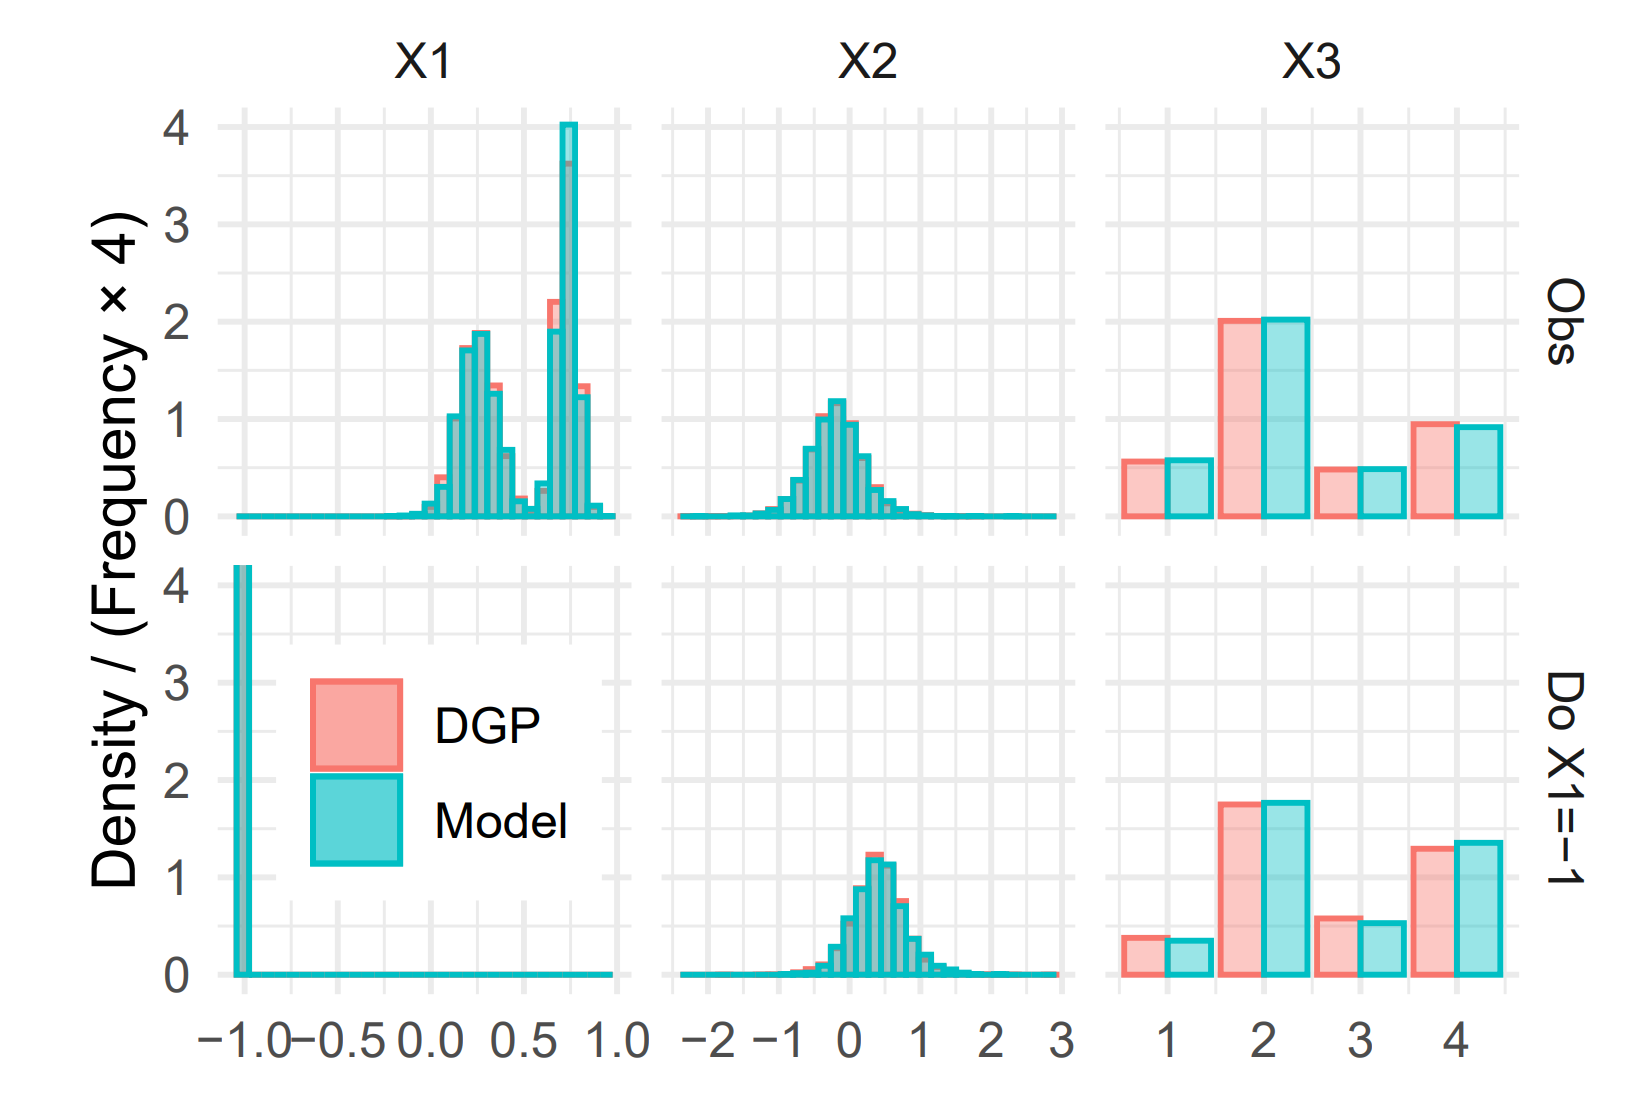

In [ ]:

# verbose = False
# batch_size = 4112

# x = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (100, 1)


# def f(x):
#     return 0.75*np.arctan(5*(x+0.12))  
# for node in node_list:
#     print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')

#     if node_list[node]['node_type'] == 'source':
#         print("Node type : source, not supported yet.")
#         continue

#     # Load model
#     NODE_DIR = os.path.join(EXPERIMENT_DIR, node)
#     model_path = os.path.join(NODE_DIR, "best_model.pt")

#     tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=False)
#     tram_model.load_state_dict(torch.load(model_path, map_location=device))
#     tram_model.to(device)   # <--- Move model to device
#     tram_model.eval()
    
#     for i, module in enumerate(tram_model.nn_shift):
#         module_name = module.__class__.__name__
#         if module_name == 'LinearShift':
#             print(f"Module {i} ({module_name}) weights:")
#             print(module.fc.weight.data)
#         else:
#             print(f"Module {i} ({module_name}) predictions:")
#             with torch.no_grad():
#                 y = module(x)
# plt.scatter(x.cpu().numpy(),y.cpu().numpy())
# plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")
# plt.show()

In [ ]:
    # def linear_shifts_from_model(self,state='best'):
    #     nodes_list = list(self.models.keys())
        
    #     linear_shift_dict={}
    #     for node in nodes_list:
    #         EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
    #         NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")
    #         BEST_MODEL_PATH, LAST_MODEL_PATH, _, _ = model_train_val_paths(NODE_DIR)
            
    #         if state=='best':
    #             LOAD_PATH=BEST_MODEL_PATH
    #         elif state=='last':
    #             LOAD_PATH=LAST_MODEL_PATH
                
    #         if not  os.path.exists(LOAD_PATH):
    #             LOAD_PATH = os.path.join(NODE_DIR, 'initial_model.pt')
    #             print(f"[WARNING] Model file not found for node {node} at {LOAD_PATH}. Using initial model instead.")
            
            
    #         state_dict = torch.load(LOAD_PATH, map_location=self.device)
    #         tram_model=self.models[node]
    #         tram_model.load_state_dict(state_dict)


    #         if  hasattr(tram_model, "nn_shift") and tram_model.nn_shift is not None:
    #             epoch_weights = {}
    #             for i, shift_layer in enumerate(tram_model.nn_shift):
    #                 module_name = shift_layer.__class__.__name__
    #                 if hasattr(shift_layer, "fc") and hasattr(shift_layer.fc, "weight") and module_name == 'LinearShift': :
                        
    #                     epoch_weights[f"shift_{i}"] = shift_layer.fc.weight.detach().cpu().tolist()
    #                 else:
    #                     if self.debug:
    #                         print(f"[DEBUG] shift_{i}: 'fc' or 'weight' or LinearShift not found.")
                            
    #             linear_shift_dict[node]=epoch_weights
    #     return linear_shift_dict